`White box` models are transparent and interpretable, meaning that their workings are completely understood and can be explained in terms of the input features and mathematical operations used to make predictions. 

`Black box` models, on the other hand, are not transparent or interpretable, meaning that their workings are not easily understood and it is difficult to explain how they make predictions. 

Decision tree models are white box models while XGBoost models are considered black box models. 

## 17.1 Logistic Regression Interpretation

In [1]:
import dtreeviz
from feature_engine import encoding, imputation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier
import urllib
import zipfile
from hyperopt import fmin, tpe, hp, Trials
from EffectiveXGBoost import *

In [2]:
path_url = 'https://github.com/mattharrison/datasets/raw/master/data/kaggle-survey-2018.zip'
file_name = 'kaggle-survey-2018.zip'
dataset = 'multipleChoiceResponses.csv'

raw = extract_dataset(path_url, file_name, dataset)

# Create raw X and raw y
kag_X, kag_y = prepX_y(raw, 'Q6')

# Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = (model_selection
                                                    .train_test_split(kag_X, 
                                                                      kag_y, 
                                                                      test_size=.3, 
                                                                      random_state=42, 
                                                                      stratify=kag_y)
                                                   )


# Transform X with pipeline
pline = pipeline.Pipeline(
    [('tweak', PrepDataTransformer()),
    ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True,
    variables=['Q1', 'Q3', 'major'])),
    ('num_impute', imputation.MeanMedianImputer(imputation_method='median',
                variables=['education', 'years_exp']))]
    )

X_train = pline.fit_transform(kag_X_train)
X_test = pline.transform(kag_X_test)

# Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)

# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

# Default training
xg = xgb.XGBClassifier()
xg.fit(X_train, y_train)

G:\My Drive\SisengAI\AlgorithmicTrading\code_rebuilding\MattHarrison\EffectiveXGBoost\EffectiveXGBoost_MyTake\EffectiveXGBoost.py:62: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [4]:
from sklearn import linear_model, preprocessing
std = preprocessing.StandardScaler()
lr = linear_model.LogisticRegression(penalty='none')
lr.fit(std.fit_transform(X_train), y_train)
lr.score(std.transform(X_test), y_test)

0.7337016574585635

Seems like the logistic regression gave similar results as the xgboost model. We would use the simpler model instead. Let us look more closely at the weights of the model using the `'.coef_'`attribute. Following scikit learn’s convention of adding an
underscore to the attribute learned while training the model.

In [5]:
lr.coef_

array([[-1.59051061e-01, -4.02827023e-01,  6.06203075e-01,
        -1.45922113e-01, -8.12626418e-02, -6.05916337e-01,
         3.18051156e-02,  3.15043497e-02, -3.13556662e-02,
        -4.75174987e-04, -8.04790381e-03, -5.22558905e-02,
        -5.08749356e-03,  1.01987638e-01,  3.50075802e-01,
        -1.79333801e-01,  2.44937585e-02, -3.38714464e-01]])

<AxesSubplot:>

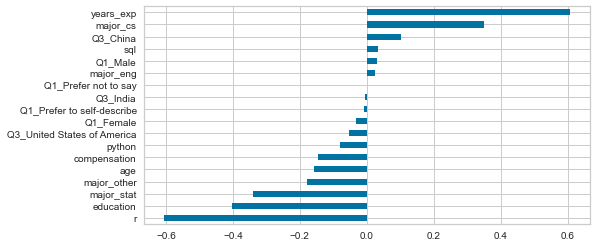

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))

(pd.Series(lr.coef_[0], index=X_train.columns)
.sort_values()
.plot.barh(ax=ax)
)

The wider the bar, the higher the impact of the feature. Positive values push towards
the positive label (or Software Engineer). Negative labels push towards the negative
label (or Data Scientist). The 'years_exp' (years of experience) column correlates with software engineering,
and using the R language (found in the 'r' column) correlates with data science. Also, the 'Q1_Prefer not to say' feature
does not have much impact on this model.

Maybe we should make an even simpler model that only considers features that have an _absolute_ value above 0.2.

## 17.2 Decision Tree Interpretation

Another white box model. Let us train one with a depth of 7.

In [7]:
tree7 = tree.DecisionTreeClassifier(max_depth=7)
tree7.fit(X_train, y_train)
tree7.score(X_test, y_test)

0.7337016574585635

In [8]:
tree7.feature_importances_

array([0.05822293, 0.09703777, 0.16172175, 0.08914157, 0.00303678,
       0.28834526, 0.01570148, 0.00530231, 0.00684056, 0.00372007,
       0.        , 0.05648182, 0.00414392, 0.0060086 , 0.17292726,
       0.00133682, 0.01253835, 0.01749275])

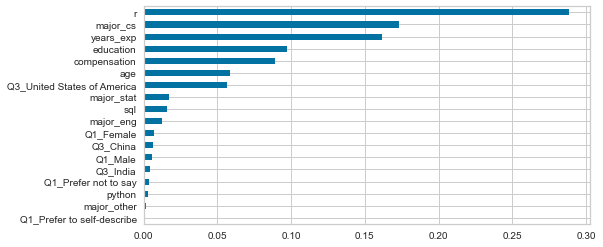

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))

_=(pd.Series(tree7.feature_importances_, index=X_train.columns)
.sort_values()
.plot.barh(ax=ax)
)


Seems like in this case the feature importances of the decision tree are not necessarily
the same as the coefficients of the logistic regression model.

C:\Users\ricky\miniconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


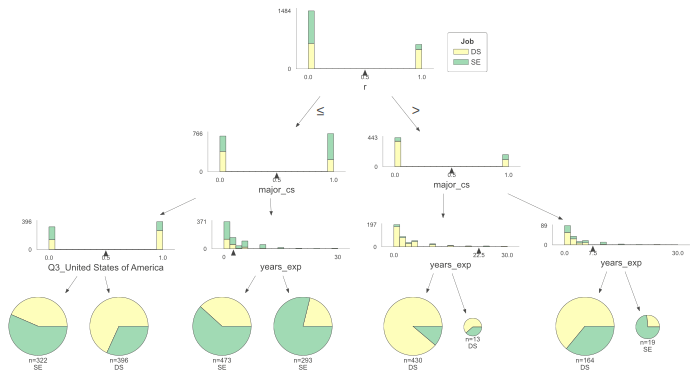

In [11]:
#import dtreeviz
dt3 = tree.DecisionTreeClassifier(max_depth=3)
dt3.fit(X_train, y_train)
viz = dtreeviz.model(dt3, X_train=X_train, y_train=y_train,
feature_names=list(X_train.columns), target_name='Job',
class_names=['DS', 'SE'])
viz.view()


## 17.3 XGBoost Feature Importance

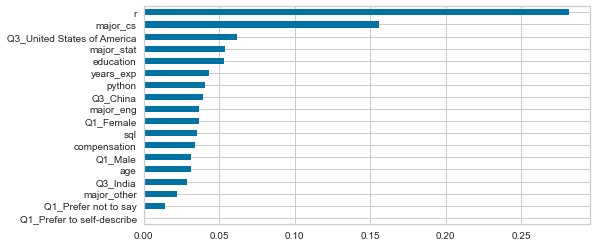

In [13]:
xgb_def = xgb.XGBClassifier()
xgb_def.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(8, 4))

_=(pd.Series(xgb_def.feature_importances_, index=X_train.columns)
.sort_values()
.plot.barh(ax=ax)
)

XGBoost models using the `.plot_importance` method. This method has an `importance_type` parameter that allows you to change how importance is measured. The different types of feature importance are:

- **Gain**: This measures the total gain in the model's performance that results from using a feature. It is calculated as the average gain of splits that use the feature.
- **Weight**: This measures the number of times a feature is used in the model. It is calculated as the number of times a feature is used to split the data across all trees.
- **Cover**: This measures the number of samples that are affected by a feature. It is calculated as the average coverage of splits that use the feature.

These different types of feature importance provide different perspectives on the importance of features in an XGBoost model.

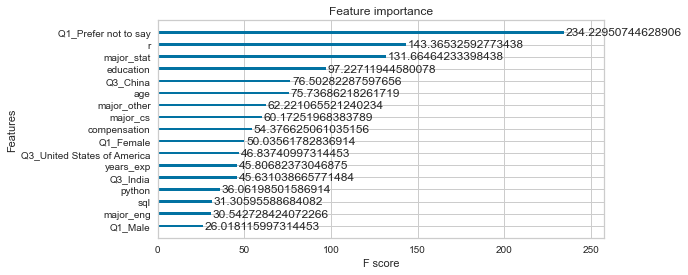

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))
_=xgb.plot_importance(xgb_def, importance_type='cover', ax=ax)

## 17.4 Surrogate Models

Another way to tease apart the XGBoost model is to train a decision tree to its predictions and
then explore the interpretable decision tree. 

In [17]:
from sklearn import tree
sur_reg_sk = tree.DecisionTreeRegressor(max_depth=4)
sur_reg_sk.fit(X_train, xgb_def.predict_proba(X_train)[:,-1])

DecisionTreeRegressor(max_depth=4)

We are going to export the tree to examine it. using the `export_graphviz` function so the image goes from left to right. We will convert the `.dot `file to a `.png` before generating it.

In [19]:
# to convert DOT to PNG
tree.export_graphviz(sur_reg_sk, 
                     out_file='img/sur-sk.dot',
                     feature_names=X_train.columns, 
                     filled=True, rotate=True,fontname='Roboto Condensed')

In [22]:
dot -Gdpi=300 -Tpng -oimg/sur-sk.png img/sur-sk.dot # HIDE

SyntaxError: cannot assign to operator (3541661493.py, line 1)

In [21]:
dot -Tpng img/sur-sk.dot -o img/sur-sk.png

SyntaxError: invalid syntax (4146176678.py, line 1)


(dot.exe:27028): Pango-WARNING **: couldn't load font "Roboto Condensed Not-Rotated 14", falling back to "Sans Condensed Not-Rotated 14", expect ugly output.

(dot.exe:27028): Pango-WARNING **: couldn't load font "Sans Condensed Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.


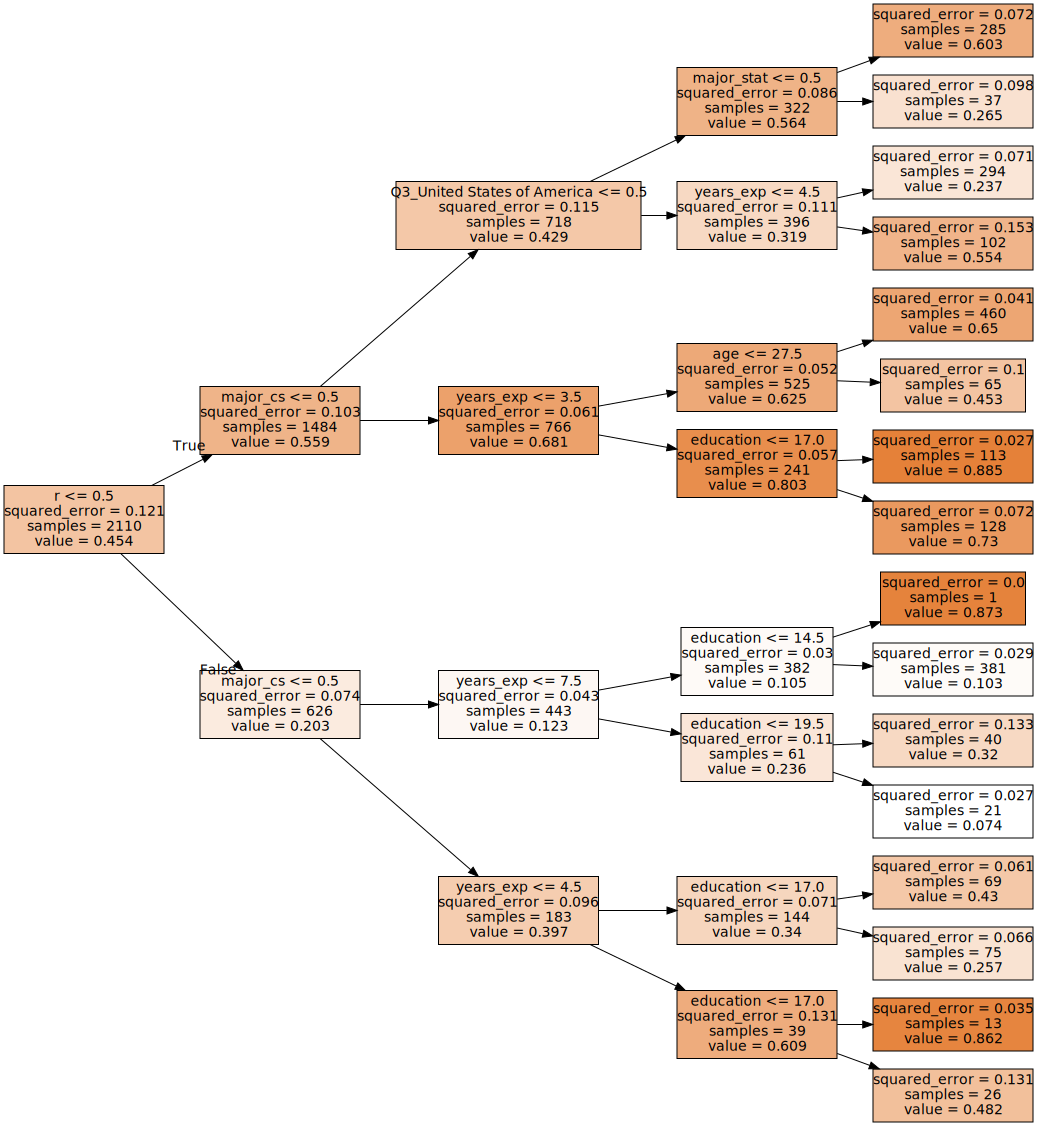

In [24]:
import graphviz
# Load the DOT file
with open('img/sur-sk.dot') as f:
    dot_graph = f.read()

# Create a graph from the DOT data
graph = graphviz.Source(dot_graph)

# Display the graph in the Jupyter notebook
graph


The warnings you're seeing indicate that the `dot` command-line tool from Graphviz is unable to find the specified font ("Roboto Condensed") on your system. As a result, it's falling back to a default font ("Sans"), which may result in suboptimal output.

To fix this issue, you can try installing the "Roboto Condensed" font on your system. The process for doing this varies depending on your operating system. On Windows, you can download the font from the Google Fonts website (https://fonts.google.com/specimen/Roboto+Condensed) and then double-click the downloaded file to install it. On macOS, you can use the Font Book application to install the font. On Linux, the process varies depending on your distribution and desktop environment.

Alternatively, you can modify the code that generates the DOT file to use a different font that is already installed on your system. For example, you can change the `fontname` parameter of the `export_graphviz` function to specify a different font:

```python
tree.export_graphviz(sur_reg_sk, out_file='img/sur-sk.dot',
                     feature_names=X_train.columns, filled=True,
                     rotate=True, fontname='Arial')
```

This will generate a DOT file that uses the "Arial" font instead of "Roboto Condensed". You can then use the `dot` command-line tool or the `graphviz` Python library to generate an image from the DOT file as described in my previous responses.